### Table of Contents
* 1. [Purpose](#Purpose)
* 2. [Exploratory Data Analysis (EDA)](#Exploratory_Data_Analysis)  
* 3. [Model Training](#Model_Training_and_Evaluation)  
* 3. [Evaluation](#Evaluation)

### **1. Purpose**

The objective of this project is to predict the **number of days a DVD is rented** based on various rental features. 

Key input features for the prediction include:

1. **Special Features** (e.g., Deleted Scenes, Behind the Scenes)  
2. **Rental Dates** (rental_date and return_date, processed to calculate rental duration)  

Two machine learning models were utilized for this task:  
1. **Linear Regression**  
2. **Random Forest Regressor**  

The performance of these models was evaluated and compared using the following metrics:
- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Error (MAE)**  
- **R² (Coefficient of Determination)**  

Another aim is to identify the most accurate model for predicting rental duration.


### **2. Exploratory Data Analysis (EDA)**

In [9]:
 # Start your coding from below
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Run OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Read in data
df_rental = pd.read_csv("rental_info.csv")
df_rental.head(3)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [16]:
# Add information on rental duration
df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days

### Add dummy variables
# Add dummy for deleted scenes
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1, 0)
# Add dummy for behind the scenes
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1, 0)

# Choose columns to drop
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]

df_rental.head(3)


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3 days 20:46:00,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2 days 20:05:00,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7 days 05:44:00,7,0,1


### **3. Model Training**

In [4]:
# Split into feature and target sets
X = df_rental.drop(cols_to_drop, axis=1)
y = df_rental["rental_length_days"]

# Further split into training and test data
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.2, 
                                                 random_state=9)

# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state=9) 

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Perform feature selectino by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

# Run OLS models on lasso chosen regression
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rand_search.best_params_

# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

# Random forest gives lowest MSE so:
best_model = rf
best_mse = mse_random_forest

### **4. Evaluation**

Linear Regression Performance:
MSE: 4.8123
RMSE: 2.1937
MAE: 1.8276
R²: 0.3222
Adjusted R²: 0.3192
------------------------------
Random Forest Performance:
MSE: 2.3577
RMSE: 1.5355
MAE: 1.2519
R²: 0.6679
Adjusted R²: 0.6664
------------------------------
Best Model: RandomForestRegressor


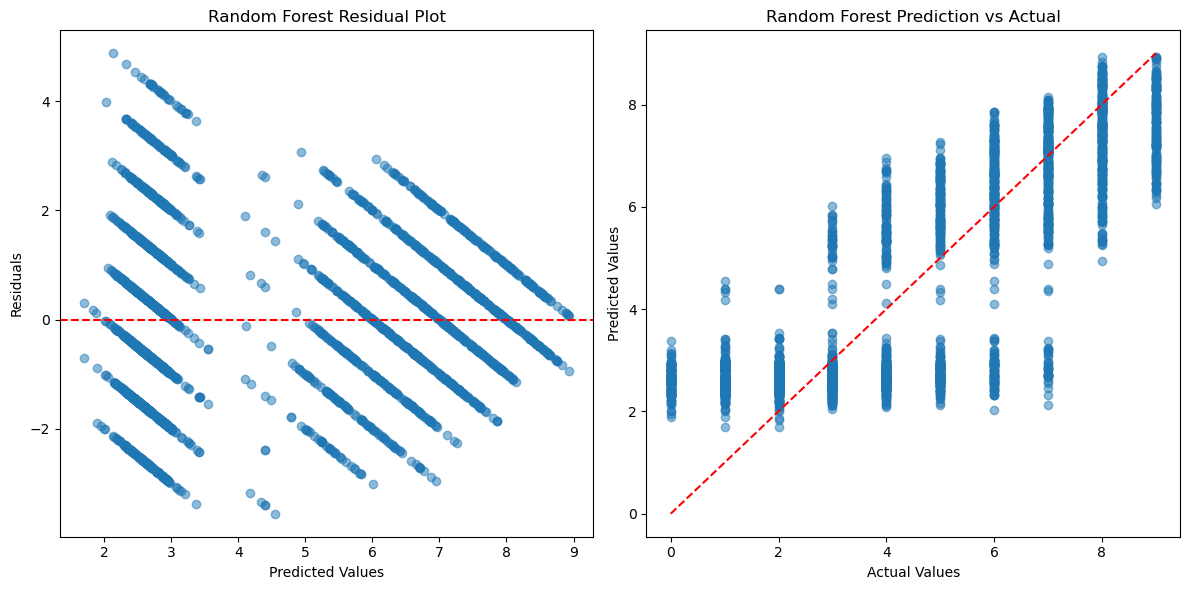

In [29]:

# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1)
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")
    print("-" * 30)
    return mse, rmse, mae, r2, adj_r2

# Evaluate OLS
metrics_ols = evaluate_model(y_test, y_pred_ols, "Linear Regression")

# Evaluate Random Forest
metrics_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Model selection
if metrics_rf[0] < metrics_ols[0]:
    best_model = rf_best
    best_mse = metrics_rf[0]
else:
    best_model = ols
    best_mse = metrics_ols[0]

print(f"Best Model: {type(best_model).__name__}")

# Visualization
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_rf, y_test - y_pred_rf, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Random Forest Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# Prediction vs Actual Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest Prediction vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()


In [25]:
# Display predictions for a subset of test data
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "OLS Prediction": y_test_pred,
    "RF Prediction": rf_pred
}).head(10)  # Display first 10 predictions
print(predictions_df)


       Actual  OLS Prediction  RF Prediction
15067       8        4.771983       7.378749
3808        1        4.777559       2.722969
1015        6        4.859621       2.151524
12617       9        4.785107       7.815241
1711        5        4.850552       2.532210
508         3        2.808654       2.482813
3008        1        2.755568       4.038611
12810       0        2.747934       2.533893
4776        6        5.510557       6.633990
10275       7        4.858712       7.473174
